In [1]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd

import pandas as pd
from pandas.errors import SettingWithCopyWarning
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr


from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
from shapely import wkt

import datetime
from datetime import date
import traceback

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=SettingWithCopyWarning) 
# SettingWithCopyWarning

In [2]:
manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_REDO_all_2020_2023-03-29dask_mega_function.csv")
manyfr.columns
manyfr["func_failed"].unique()
debug = manyfr[(manyfr["func_failed"] == 'load_large_fire/get_gpm')  ]
manyfr = manyfr[(manyfr["func_failed"] != 'load_large_fire/get_gpm')  ]

manyfr = manyfr[manyfr.n_pixels.notna()]
manyfr = manyfr.sort_values(by = ["t"])

manyfr.geometry = manyfr.geometry.apply(wkt.loads)
manyfr = gpd.GeoDataFrame(manyfr, geometry = "geometry")

### Static Source filtering
dirextdata = '/projects/shared-buckets/gsfc_landslides/FEDSinput/'
source = "VIIRS_Global_flaring_d.7_slope_0.029353_2017_web_v1.csv"


global_flaring = gpd.read_file(os.path.join(dirextdata,'static_sources', source))
global_flaring = global_flaring.drop_duplicates()
global_flaring = global_flaring[0:(len(global_flaring.id_key_2017) - 1)]

global_flaring = gpd.GeoDataFrame(global_flaring, geometry=gpd.points_from_xy(global_flaring.Longitude, global_flaring.Latitude))

global_flaring["buffer_geometry"] = global_flaring.buffer(0.2)

global_flaring = global_flaring.set_geometry(col = "buffer_geometry")
global_flaring.geometry

with_sources = len(manyfr.fireID.unique())
joinfr = gpd.sjoin(manyfr, global_flaring, how='left', op='within')
joinfr = joinfr[joinfr.geometry_right.isna()]

manyfr = manyfr[manyfr.fireID.isin(joinfr.fireID.unique())]

no_sources = len(manyfr.fireID.unique())

print("With souces, 2020 had ", with_sources, " fires over 5km ^2. Filtering removed to that we were left with ", no_sources)

/tmp/ipykernel_3917/1060935600.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,11,12,16,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_REDO_all_2020_2023-03-29dask_mega_function.csv")
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


With souces, 2020 had  553  fires over 5km ^2. Filtering removed to that we were left with  466


In [3]:
def percent_spread_time(manyfr):
    
    time = manyfr.t.unique()

    time_sum = []
    for i in time: 
        #print(i)
        try:
            at_t = manyfr[manyfr.t == i]
            at_t_spread = at_t[(at_t.spread_line.astype("str") == 'True') | (at_t.spread_line.astype("str") == '1')]
            at_t_ig = at_t[at_t.spread_line.astype("str") == "2"]
            at_t_not_spread = at_t[(at_t.spread_line.astype("str") == 'False') | (at_t.spread_line.astype("str") == '0')]
        except:
            print("Skipping ", i)
            next
        else:
            num_fires = len(at_t.fireID)
            num_spread = len(at_t_spread.fireID)
            num_ig = len(at_t_ig.fireID)

            num_percent_spread = num_spread/num_fires
            num_percent_spread_ig = (num_spread + num_ig)/num_fires
            num_percent_ig = num_ig/num_fires

            fire_labs_all = str(at_t.fireID)
            fire_labs_spread = str(at_t_spread.fireID)
            fire_labs_ig = str(at_t_ig.fireID)

            area = sum(at_t.farea.astype("float").dropna())
            area_spread = sum(at_t_spread.farea.astype("float").dropna())

            delta_area = sum(at_t.farea_diff.astype("float").dropna())
            #print(at_t)
            delta_area_spread = sum(at_t_spread.farea_diff.astype("float").dropna().values)
            #print(delta_area_spread)
            delta_area_ig = sum(at_t_ig.farea.astype("float").dropna()) ## Repeats from dat to night

            area_percent_spread = area_spread/area
            area_percent_spread_ig = (area_spread + delta_area_ig)/area
            area_percent_ig = (delta_area_ig)/area

            delta_area_percent_spread = delta_area_spread/area
            delta_area_percent_spread_ig = (delta_area_spread + delta_area_ig)/area

            mean_spread_fwi = np.mean(at_t_spread['GEOS-5_FWI'].astype("float").dropna())
            mean_not_spread_fwi = np.mean(at_t_not_spread['GEOS-5_FWI'].astype("float").dropna())
            max_spread_fwi = np.max(at_t_spread['GEOS-5_FWI'].astype("float").dropna())

            time_sum.append([i, num_fires,num_spread, num_ig, 
                             num_percent_spread,num_percent_spread_ig,num_percent_ig, 
                             fire_labs_all, fire_labs_spread, fire_labs_ig, 
                             area, area_spread,
                             delta_area, delta_area_spread, delta_area_ig,
                             area_percent_spread, area_percent_spread_ig, area_percent_ig, 
                             delta_area_percent_spread, delta_area_percent_spread_ig, 
                             mean_spread_fwi, mean_not_spread_fwi, max_spread_fwi])
            
    timeline = pd.DataFrame(data = time_sum, columns = ["t",'num_fires','num_spread', 'num_ig', 
                                                        'num_percent_spread', 'num_percent_spread_ig', 'num_percent_ig', 
                                                        'fire_labs_all', 'fire_labs_spread', 'fire_labs_ig', 
                                                        'area', 'area_spread', 
                                                        'delta_area', 'delta_area_spread', 'delta_area_ig',
                                                        'area_percent_spread', 'area_percent_spread_ig', 'area_percent_ig',
                                                        'delta_area_percent_spread', 'delta_area_percent_spread_ig',
                                                        "mean_spread_fwi", "mean_not_spread_fwi", "max_spread_fwi"])
    return(timeline)

In [4]:
### For loop of percent spread
## find all fireids in snapshot
pnw = gpd.read_file("/projects/my-public-bucket/fire_weather_vis/ref_data/NEON_DOMAIN/NEON_Domains.shp")# quickly subset by state to avoid computational stuff
#pnw = pnw[pnw.DomainID == 16]
pnw.set_crs('EPSG:4326')
manyfr.set_crs('EPSG:4326')
#join = gpd.tools.sjoin(manyfr,pnw, predicate="within")
#ids = join.fireID.unique()

pnw = pnw.set_crs('EPSG:4326')

pnw["x"] = pnw.centroid.x
pnw["y"] = pnw.centroid.y
#pnw.DomainName.astype("str")

/tmp/ipykernel_3917/3519595798.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pnw["x"] = pnw.centroid.x
/tmp/ipykernel_3917/3519595798.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pnw["y"] = pnw.centroid.y


In [5]:
### Read in stations by thier NEON region


files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon
st_id_map["WBAN"] = st_id_map["WBAN"].astype('str')
# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')

## Merge station map and stations

stats = pd.merge(stations, st_id_map, "outer", on = ['USAF',  'WBAN'])
stats = gpd.GeoDataFrame(stats, geometry=gpd.points_from_xy(stats.Lon, stats.Lat))

## Merge stations with neon shapefiles

#stats = gpd.sjoin()

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


In [6]:
stats = gpd.sjoin(stats, pnw, predicate='within')
#?pd.merge

/tmp/ipykernel_3917/2572062463.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  stats = gpd.sjoin(stats, pnw, predicate='within')


In [7]:
stats.columns

Index(['File_path', 'Lat', 'Lon', 'USAF', 'WBAN', 'STATION NAME', 'CTRY',
       'STATE', 'ICAO', 'LAT', 'LON', 'ELEV(M)', 'BEGIN', 'END', 'geometry',
       'index_right', 'OBJECTID', 'Shape_Leng', 'DomainID', 'DomainName',
       'Shape_Le_1', 'Shape_Area', 'x', 'y'],
      dtype='object')

In [8]:
### Read in all stations from a region, and merge into a mega dataframe

def read_st(df, time_start = '2020-04-01 12:00:00', time_end = '2020-10-31 20:00:00'):
    
    stations = []
    st = df.File_path
    for i, s in enumerate(st):
        
        dat = pd.read_csv(("s3://" + s), index_col = False)
        dat = fv.date_convert(dat)
    
#         if flag_bad:
#             mask = dat['OBSMINUTEDIFFTEMP'].loc[dat.OBSMINUTEDIFFTEMP > 20]  ## Kluge. Basically, use this as a flag. 
#             dat.iloc[mask.index, 3:-4 ] = np.nan

        if ((time_start != "default") & (time_end != "default")):

            dat = dat[(dat['time'] > time_start) & (dat['time'] < time_end )] # For "zooming" to particular time

        dat["DoimainName"] = df['DomainName'].iloc[i]
        dat["USAF"] = df['USAF'].iloc[i]
        dat['WBAN'] = df['WBAN'].iloc[i]
        dat['WBAN_USAF'] = df['WBAN'].iloc[i] + df['USAF'].iloc[i]
        dat['STATION NAME'] = df['STATION NAME'].iloc[i]
        dat['ELEV(M)'] = df['ELEV(M)'].iloc[i]
        dat['LAT'] = df['LAT'].iloc[i]
        dat['LON'] = df['LON'].iloc[i]
        stations.append(dat)
    
    return(pd.concat(stations))
        

In [60]:
# dat = pd.read_csv(("s3://" + smol.File_path.iloc[0]), index_col = False)
# dat = fv.date_convert(dat)
# #smol.File_path.iloc[0]
# dat

/tmp/ipykernel_13407/1497393384.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + smol.File_path.iloc[0]), index_col = False)


,YYYY,MM,DD,HH,TEMP_C,RH_PERC,VPD_HPA,WDSPD_KPH,PREC_MM,SNOWD_M,...,BUI,ISI,FWI,OBSMINUTEDIFFTEMP,OBSMINUTEDIFFRH,OBSMINUTEDIFFWDSPD,OBSMINUTEDIFFPREC,OBSMINUTEDIFFSNOW,HH_format,time
0,1999,12,31,16,1.8366,90.971,0.622180,3.737900,0.0,0,...,NaN,NaN,NaN,30,30,30,30,NaN,16,1999-12-31 16:00:00
1,1999,12,31,17,0.6000,95.752,0.271920,5.400000,0.0,0,...,NaN,NaN,NaN,0,0,0,0,NaN,17,1999-12-31 17:00:00
2,1999,12,31,18,0.0000,100.000,0.000000,0.000000,0.0,0,...,NaN,NaN,NaN,0,0,0,0,NaN,18,1999-12-31 18:00:00
3,1999,12,31,19,-1.0227,99.968,0.001968,5.353000,0.0,0,...,NaN,NaN,NaN,4,4,4,4,NaN,19,1999-12-31 19:00:00
4,1999,12,31,20,-0.6000,100.000,0.000000,0.000000,0.0,0,...,NaN,NaN,NaN,0,0,0,0,NaN,20,1999-12-31 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199251,2022,9,23,19,23.0350,34.996,18.220000,0.000000,0.0,0,...,NaN,4.7953,22.541,7,7,7,7,NaN,19,2022-09-23 19:00:00
199252,2022,9,23,20,21.9170,40.826,15.661000,0.126350,0.0,0,...,NaN,4.8259,22.643,7,7,7,7,NaN,20,2022-09-23 20:00:00
199253,2022,9,23,21,18.6740,53.111,10.047000,0.000000,0.0,0,...,NaN,4.6542,22.068,7,7,7,7,NaN,21,2022-09-23 21:00:00
199254,2022,9,23,22,18.2280,54.278,9.595300,0.010005,0.0,0,...,NaN,4.5134,21.589,7,7,7,7,NaN,22,2022-09-23 22:00:00


In [9]:
smol = stats[stats.DomainName == 'Pacific Northwest']

In [10]:
smol_st = read_st(smol)

/tmp/ipykernel_3917/3448998995.py:9: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + s), index_col = False)
/tmp/ipykernel_3917/3448998995.py:9: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + s), index_col = False)
/tmp/ipykernel_3917/3448998995.py:9: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + s), index_col = False)
/tmp/ipykernel_3917/3448998995.py:9: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + s), index_col = False)
/tmp/ipykernel_3917/3448998995.py:9: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with i

In [28]:
smol_st.groupby("time").describe()

YYYY                                               \
                    count    mean  std     min     25%     50%     75%   
time                                                                     
2020-04-01 13:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
2020-04-01 14:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
2020-04-01 15:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
2020-04-01 16:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
2020-04-01 17:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
...                   ...     ...  ...     ...     ...     ...     ...   
2020-10-31 15:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
2020-10-31 16:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
2020-10-31 17:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
2020-10-31 18:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   
2020-10-31 19:00:00   8.0  2020.0  0.0  2020.0  2020.0  2020.0  2020.0   

                               MM        ...       LAT           LON  \
                        max count  mean  ...       75%     max count   
time                                     ...                           
2020-04-01 13:00:00  2020.0   8.0   4.0  ...  47.09175  47.937   8.0   
2020-04-01 14:00:00  2020.0   8.0   4.0  ...  47.09175  47.937   8.0   
2020-04-01 15:00:00  2020.0   8.0   4.0  ...  47.09175  47.937   8.0   
2020-04-01 16:00:00  2020.0   8.0   4.0  ...  47.09175  47.937   8.0   
2020-04-01 17:00:00  2020.0   8.0   4.0  ...  47.09175  47.937   8.0   
...                     ...   ...   ...  ...       ...     ...   ...   
2020-10-31 15:00:00  2020.0   8.0  10.0  ...  47.09175  47.937   8.0   
2020-10-31 16:00:00  2020.0   8.0  10.0  ...  47.09175  47.937   8.0   
2020-10-31 17:00:00  2020.0   8.0  10.0  ...  47.09175  47.937   8.0   
2020-10-31 18:00:00  2020.0   8.0  10.0  ...  47.09175  47.937   8.0   
2020-10-31 19:00:00  2020.0   8.0  10.0  ...  47.09175  47.937   8.0   

                                                                        \
                           mean       std      min        25%      50%   
time                                                                     
2020-04-01 13:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
2020-04-01 14:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
2020-04-01 15:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
2020-04-01 16:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
2020-04-01 17:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
...                         ...       ...      ...        ...      ...   
2020-10-31 15:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
2020-10-31 16:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
2020-10-31 17:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
2020-10-31 18:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   
2020-10-31 19:00:00 -123.170375  0.723989 -124.558 -123.38275 -122.953   

                                      
                        75%      max  
time                                  
2020-04-01 13:00:00 -122.81 -122.314  
2020-04-01 14:00:00 -122.81 -122.314  
2020-04-01 15:00:00 -122.81 -122.314  
2020-04-01 16:00:00 -122.81 -122.314  
2020-04-01 17:00:00 -122.81 -122.314  
...                     ...      ...  
2020-10-31 15:00:00 -122.81 -122.314  
2020-10-31 16:00:00 -122.81 -122.314  
2020-10-31 17:00:00 -122.81 -122.314  
2020-10-31 18:00:00 -122.81 -122.314  
2020-10-31 19:00:00 -122.81 -122.314  

[5119 rows x 184 columns]

In [12]:
#plt.plot(smol_st.time.astype("datetime64[ns]"), smol_st[' VPD_HPA'], color =  smol_st['WBAN_USAF'] )


import seaborn as sns

In [13]:
smol_st = smol_st.sort_values(by = ["time", "LAT"])

smol_st.columns

Index(['YYYY', 'MM', 'DD', 'HH', 'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'PREC_MM', 'SNOWD_M', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI',
       'OBSMINUTEDIFFTEMP', 'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD',
       'OBSMINUTEDIFFPREC', 'OBSMINUTEDIFFSNOW', 'HH_format', 'time',
       'DoimainName', 'USAF', 'WBAN', 'WBAN_USAF', 'STATION NAME', 'ELEV(M)',
       'LAT', 'LON'],
      dtype='object')

/tmp/ipykernel_3917/3436182470.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)


[Text(18353.0, 0, '2020-04'),
 Text(18383.0, 0, '2020-05'),
 Text(18414.0, 0, '2020-06'),
 Text(18444.0, 0, '2020-07'),
 Text(18475.0, 0, '2020-08'),
 Text(18506.0, 0, '2020-09'),
 Text(18536.0, 0, '2020-10'),
 Text(18567.0, 0, '2020-11')]

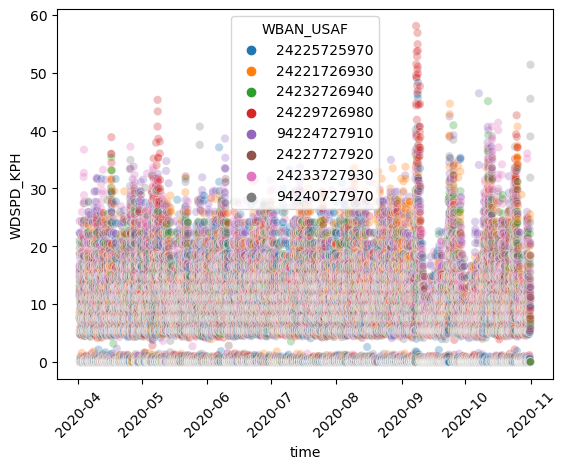

In [14]:
my_plot = sns.scatterplot(data=smol_st, 
             x = smol_st.time.astype("datetime64[ns]"), 
             y = smol_st['WDSPD_KPH'],
             hue = smol_st['WBAN_USAF'], 
             alpha = 0.3)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)

In [15]:



# sns.lineplot(data=smol_st, 
#              x = smol_st.time.astype("datetime64[ns]"), 
#              y = smol_st['FWI'].astype("float"),
#              hue = smol_st['WBAN_USAF'], 
#              alpha = 0.3)

In [ ]:
smol_st.columns

In [ ]:
smol_st